In [97]:
# Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import percent_format, date_format

# [Working with Stock Market Data](https://www.tidy-finance.org/python/introduction-to-tidy-finance.html#working-with-stock-market-data)

In [3]:
# download data and perform the dataframe
prices = (yf.download(
    tickers="AAPL",
    start="2000-01-01",
    end="2023-12-31",
    ignore_tz=True,
    progress=False
)
.reset_index()
.assign(symbol="AAPL")
.rename(columns={
    "Date": "date",
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Adj Close": "adjusted",
    "Volume": "volume"}
    )
)
prices.head().round(4)

,date,open,high,low,close,adjusted,volume,symbol
0,2000-01-03,0.9364,1.0045,0.9079,0.9994,0.8461,535796800,AAPL
1,2000-01-04,0.9665,0.9877,0.9035,0.9152,0.7748,512377600,AAPL
2,2000-01-05,0.9263,0.9872,0.9196,0.9286,0.7861,778321600,AAPL
3,2000-01-06,0.9475,0.9554,0.8482,0.8482,0.7181,767972800,AAPL
4,2000-01-07,0.8616,0.9018,0.8527,0.8884,0.7521,460734400,AAPL


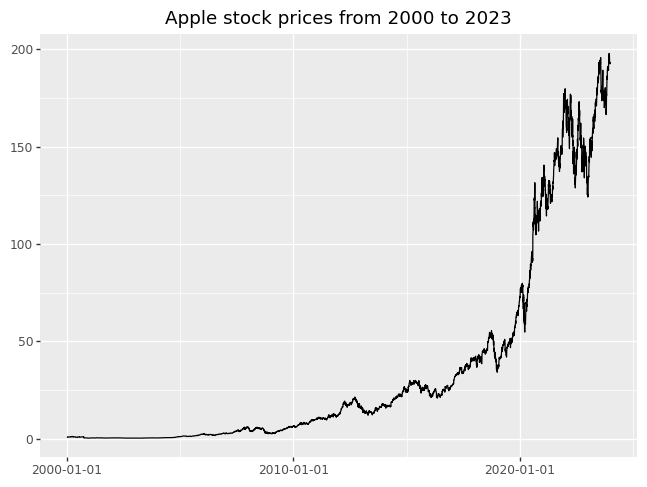

In [4]:
# visualize stock prices
prices_figure = (
    ggplot(prices, aes(y="adjusted", x="date")) +
    geom_line() +
    labs(x="", y="",
         title="Apple stock prices from 2000 to 2023")
)
prices_figure.draw()

In [5]:
# returns percentage change
returns = (prices
    .sort_values("date")
    .assign(ret=lambda x: x["adjusted"].pct_change())
    .get(["symbol", "date", "ret"])
)
returns = returns.dropna()
returns.head().round(4)

,symbol,date,ret
1,AAPL,2000-01-04,-0.0843
2,AAPL,2000-01-05,0.0146
3,AAPL,2000-01-06,-0.0865
4,AAPL,2000-01-07,0.0474
5,AAPL,2000-01-10,-0.0176


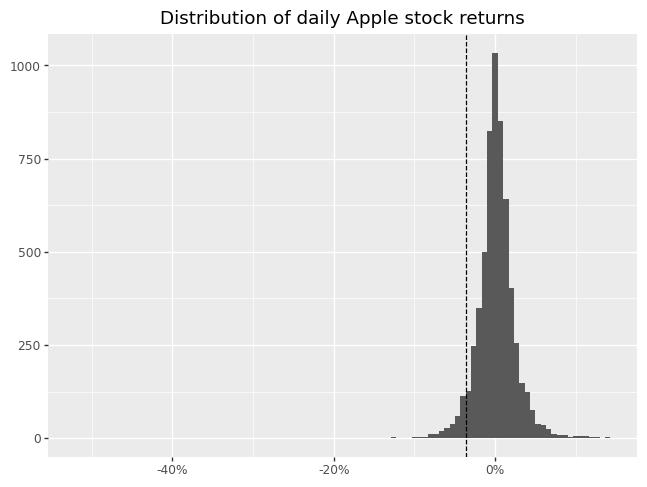

In [6]:
# determine the fifth 5 percent quartile to determine the VaR
quantile_05 = returns["ret"].quantile(0.05)
returns_figure = (
    ggplot(returns, aes(x="ret")) +
    geom_histogram(bins=100) +
    geom_vline(aes(xintercept=quantile_05),
               linetype="dashed") +
    labs(x="", y="",
         title="Distribution of daily Apple stock returns") +
    scale_x_continuous(labels=percent_format())
)
returns_figure.draw()

In [7]:
# statistics for total returns
pd.DataFrame(returns["ret"].describe()).round(3).T

,count,mean,std,min,25%,50%,75%,max
ret,6036.0,0.001,0.025,-0.519,-0.01,0.001,0.013,0.139


In [8]:
# Annualized
pd.DataFrame(returns["ret"]
    .groupby(returns["date"].dt.year)
    .describe()
).round(3)

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2000,251.0,-0.003,0.055,-0.519,-0.034,-0.002,0.027,0.137
2001,248.0,0.002,0.039,-0.172,-0.023,-0.001,0.027,0.129
2002,252.0,-0.001,0.031,-0.150,-0.019,-0.003,0.018,0.085
2003,252.0,0.002,0.023,-0.081,-0.012,0.002,0.015,0.113
2004,252.0,0.005,0.025,-0.056,-0.009,0.003,0.016,0.132
2005,252.0,0.003,0.024,-0.092,-0.010,0.003,0.017,0.091
2006,251.0,0.001,0.024,-0.063,-0.014,-0.002,0.014,0.118
2007,251.0,0.004,0.024,-0.070,-0.009,0.003,0.018,0.105
2008,253.0,-0.003,0.037,-0.179,-0.024,-0.001,0.019,0.139


# [Scaling Up the Analysis](https://www.tidy-finance.org/python/introduction-to-tidy-finance.html#scaling-up-the-analysis)

In [9]:
# donwload the symbols that make up the Dow Jones index
url = ("https://www.ssga.com/us/en/institutional/etfs/library-content/"
       "products/fund-data/etfs/us/holdings-daily-us-en-dia.xlsx")
symbols = (pd.read_excel(url, skiprows=4, nrows=30)
       .get("Ticker")
       .tolist()
)

In [100]:
# download data and perform the dataframe from wide format to long format
index_prices = (yf.download(
    tickers=symbols, 
    start="2000-01-01", 
    end="2023-12-31", 
    progress=False
  )
  .melt(ignore_index=False)
  .reset_index()
  .pivot(index=["Date", "Ticker"], columns="Price", values="value")
  .reset_index()
  .rename(columns={
    "Date": "date", 
    "Ticker": "symbol",
    "Open": "open", 
    "High": "high", 
    "Low": "low",
    "Close": "close", 
    "Adj Close": "adjusted", 
    "Volume": "volume"}
  )
  .set_index("date")
)
index_prices.columns.name = None

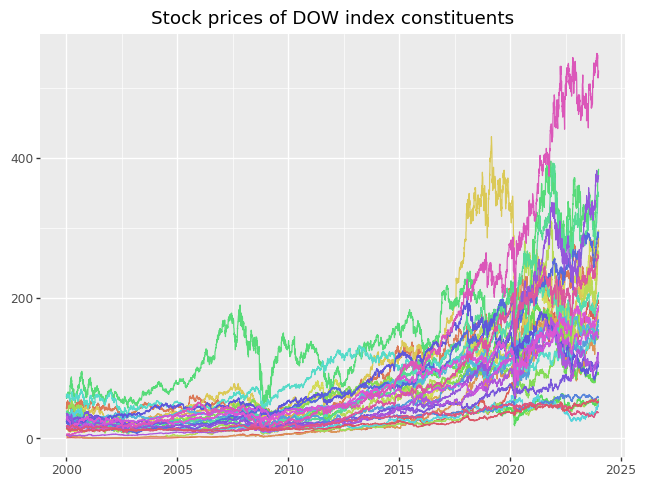

In [101]:
# visualize each DOW's stock prices
index_prices_figure = (
    ggplot(index_prices,
           aes(y="adjusted", x=index_prices.index, color="symbol")) +
           geom_line() +
           labs(x="", y="", color="",
                title="Stock prices of DOW index constituents") +
            theme(legend_position="none") +
            scale_x_datetime(date_breaks="5 years", date_labels="%Y")
)
index_prices_figure.draw()

In [119]:
# calculate total return and show statistics
all_returns = (index_prices
    .assign(ret=lambda x: x.groupby("symbol")["adjusted"].pct_change(fill_method=None))
    .get(["symbol", "ret"])
    .dropna(subset="ret")
)
(all_returns
  .groupby("symbol")["ret"]
  .describe()
  .round(3)
)

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAPL,6036.0,0.001,0.025,-0.519,-0.010,0.001,0.013,0.139
AMGN,6036.0,0.000,0.019,-0.134,-0.009,0.000,0.009,0.151
AMZN,6036.0,0.001,0.032,-0.248,-0.012,0.000,0.014,0.345
AXP,6036.0,0.001,0.023,-0.176,-0.009,0.000,0.010,0.219
BA,6036.0,0.001,0.022,-0.238,-0.010,0.001,0.011,0.243
CAT,6036.0,0.001,0.020,-0.145,-0.010,0.001,0.011,0.147
CRM,4914.0,0.001,0.027,-0.271,-0.012,0.001,0.014,0.260
CSCO,6036.0,0.000,0.023,-0.162,-0.009,0.000,0.010,0.244
CVX,6036.0,0.001,0.018,-0.221,-0.008,0.001,0.009,0.227


# [Other Forms of Data Aggregation](https://www.tidy-finance.org/python/introduction-to-tidy-finance.html#other-forms-of-data-aggregation)

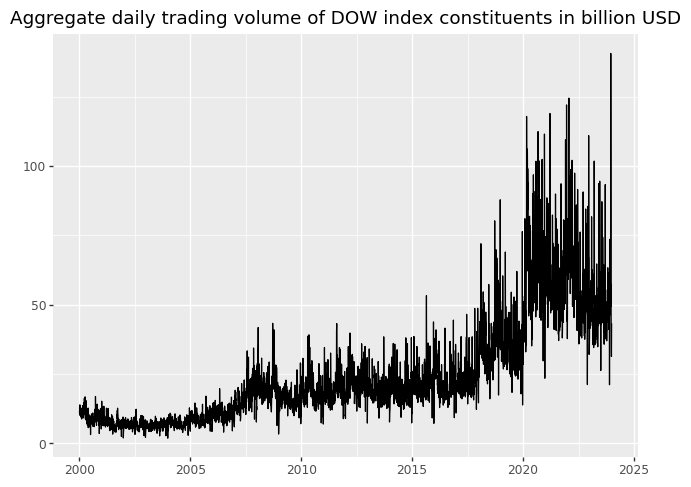

In [122]:
# trading volume in USD
trading_volume = (index_prices
    .assign(trading_volume=lambda x: (x["volume"]*x["adjusted"])/1e9)
    .groupby("date")["trading_volume"]
    .sum()
    .reset_index()
    .assign(trading_volume_lag=lambda x: x["trading_volume"].shift(periods=1))
)

trading_volume_figure = (
    ggplot(trading_volume,
           aes(x="date", y="trading_volume")) +
    geom_line() +
    labs(x="", y="",
         title=("Aggregate daily trading volume of DOW index constituents "
                "in billion USD")) +
    scale_x_datetime(date_breaks="5 years", date_labels="%Y")
)
trading_volume_figure.draw()

/usr/local/Caskroom/miniconda/base/envs/projects/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


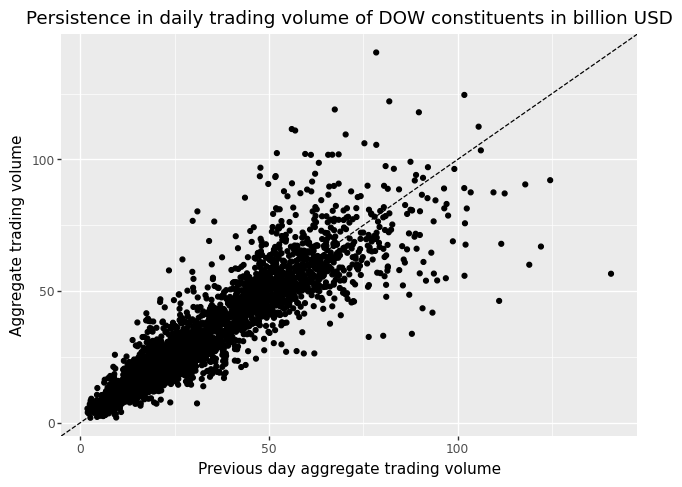

In [124]:
# plot volume on day t against volume on day t - 1
trading_volume_figure_lagged = (
    ggplot(trading_volume,
        aes(x="trading_volume_lag", y="trading_volume")) +
    geom_point() +
    geom_abline(aes(intercept=0, slope=1), linetype="dashed") +
    labs(x="Previous day aggregate trading volume",
         y="Aggregate trading volume",
         title=("Persistence in daily trading volume of DOW constituents "
                "in billion USD"))
)
trading_volume_figure_lagged.draw()